In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mcdonalds-store-reviews/McDonald_s_Reviews.csv


In [2]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd

# Load the dataset
file_path = '/kaggle/input/mcdonalds-store-reviews/McDonald_s_Reviews.csv'
df = pd.read_csv(file_path, encoding='latin1')

# Check the dataset
print(df.head())
print(df.columns)

# Drop unnecessary columns and reset the index
df = df[['review', 'rating']].dropna().reset_index(drop=True)



   reviewer_id  store_name              category  \
0            1  McDonald's  Fast food restaurant   
1            2  McDonald's  Fast food restaurant   
2            3  McDonald's  Fast food restaurant   
3            4  McDonald's  Fast food restaurant   
4            5  McDonald's  Fast food restaurant   

                                       store_address  latitude   longitude  \
0  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   
1  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   
2  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   
3  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   
4  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   

  rating_count   review_time  \
0        1,240  3 months ago   
1        1,240    5 days ago   
2        1,240    5 days ago   
3        1,240   a month ago   
4        1,240  2 months ago   

                         

## Assign Sentiment Labels 

In [4]:
def assign_sentiment(rating):
    if rating >= 4:
        return 0  # Positive
    elif rating <= 2:
        return 1  # Negative
    else:
        return 2  # Neutral

# Convert ratings to numeric and map sentiment
df['rating'] = df['rating'].str.extract('(\d+)').astype(float)
df['sentiment'] = df['rating'].apply(assign_sentiment)

# Drop unnecessary columns
df = df[['review', 'sentiment']]
print(df.head())


                                              review  sentiment
0  Why does it look like someone spit on my food?...          1
1  It'd McDonalds. It is what it is as far as the...          0
2  Made a mobile order got to the speaker and che...          1
3  My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...          0
4  I repeat my order 3 times in the drive thru, a...          1


## Analyzing Sentiment Distribution

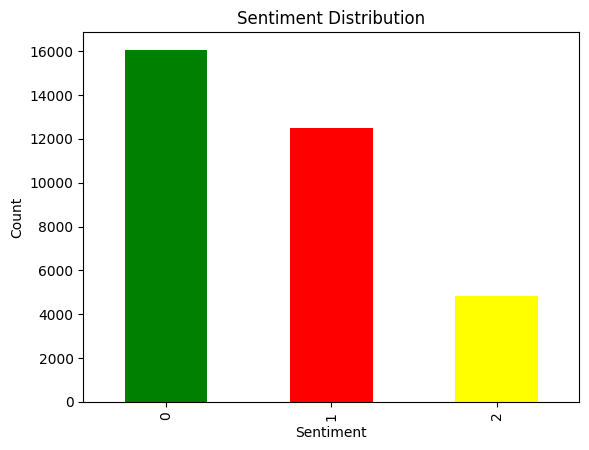

In [5]:
df['sentiment'].value_counts().plot(kind='bar', color=['green', 'red', 'yellow'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

## Dataset Splitting

In [6]:
from sklearn.model_selection import train_test_split

# Stratified split to ensure label distribution remains consistent
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['sentiment'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['sentiment'], random_state=42)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")



Train size: 26716, Validation size: 3340, Test size: 3340


## Tokenize The Text

In [7]:
from transformers import RobertaTokenizer
from datasets import Dataset

# Load tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Convert pandas DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Tokenization function
def tokenize(batch):
    return tokenizer(batch['review'], truncation=True, padding='max_length', max_length=128)

# Apply tokenization
train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# Rename sentiment column to labels
train_dataset = train_dataset.rename_column("sentiment", "labels")
val_dataset = val_dataset.rename_column("sentiment", "labels")

# Remove unnecessary columns
train_dataset = train_dataset.remove_columns(['review'])
val_dataset = val_dataset.remove_columns(['review'])
test_dataset = test_dataset.remove_columns(['review'])

# Check tokenized dataset
print(train_dataset[0])


Map:   0%|          | 0/26716 [00:00<?, ? examples/s]

Map:   0%|          | 0/3340 [00:00<?, ? examples/s]

Map:   0%|          | 0/3340 [00:00<?, ? examples/s]

{'labels': 1, '__index_level_0__': 32531, 'input_ids': [0, 27331, 2635, 544, 11, 5, 1305, 34876, 358, 881, 86, 38, 524, 259, 4, 38, 156, 127, 645, 158, 30658, 10, 213, 8, 38, 202, 2220, 29667, 4056, 9470, 14989, 29667, 4056, 9470, 14989, 29667, 4056, 9470, 14989, 29667, 4056, 9470, 14989, 29667, 4056, 9470, 14989, 29667, 4056, 9470, 14989, 29667, 4056, 9470, 14989, 29667, 4056, 9470, 14989, 29667, 4056, 9470, 14989, 29667, 4056, 9470, 14989, 29667, 4056, 9470, 14989, 29667, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

## Define the Model

In [8]:
from transformers import RobertaForSequenceClassification

# Load the model with 3 output labels (positive, negative, neutral)
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3, output_hidden_states=False)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    return {"eval_accuracy": accuracy}


In [10]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    evaluation_strategy='epoch',
    logging_dir='./logs',
    logging_steps=10,
    save_total_limit=2,
    fp16=True,  # Use mixed precision for faster training
    dataloader_num_workers=0,  # Optimize data loading
    report_to='none',  # Disable W&B logging
    weight_decay=0.01,  # Regularization to prevent overfitting
    learning_rate=2e-5  # Reduce learning rate slightly
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [11]:
from transformers import TrainerCallback, Trainer

class EpochEndCallback(TrainerCallback):
    def on_epoch_end(self, args, state, control, **kwargs):
        print(f"Epoch {state.epoch} completed. Global Step: {state.global_step}")

trainer=Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    callbacks=[EpochEndCallback()],
    compute_metrics=compute_metrics
)


trainer.train()


<ipython-input-11-7fff5d5784a6>:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer=Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.352000,0.407273,0.844012
2,0.383400,0.423646,0.854790
3,0.237800,0.460139,0.853892


Epoch 1.0 completed. Global Step: 1670
Epoch 2.0 completed. Global Step: 3340
Epoch 3.0 completed. Global Step: 5010


TrainOutput(global_step=5010, training_loss=0.36093146234691265, metrics={'train_runtime': 1093.9291, 'train_samples_per_second': 73.266, 'train_steps_per_second': 4.58, 'total_flos': 5272003551015936.0, 'train_loss': 0.36093146234691265, 'epoch': 3.0})

## Results

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract logs
logs = trainer.state.log_history

# Convert to DataFrame
logs_df = pd.DataFrame(logs)

# Filter for rows with epoch information
loss_acc_logs = logs_df[logs_df['epoch'].notnull()]

# Extract training and validation loss
epochs = loss_acc_logs['epoch']
training_loss = loss_acc_logs['loss']  # Training loss
validation_loss = loss_acc_logs.get('eval_loss', [])  # Validation loss, if available


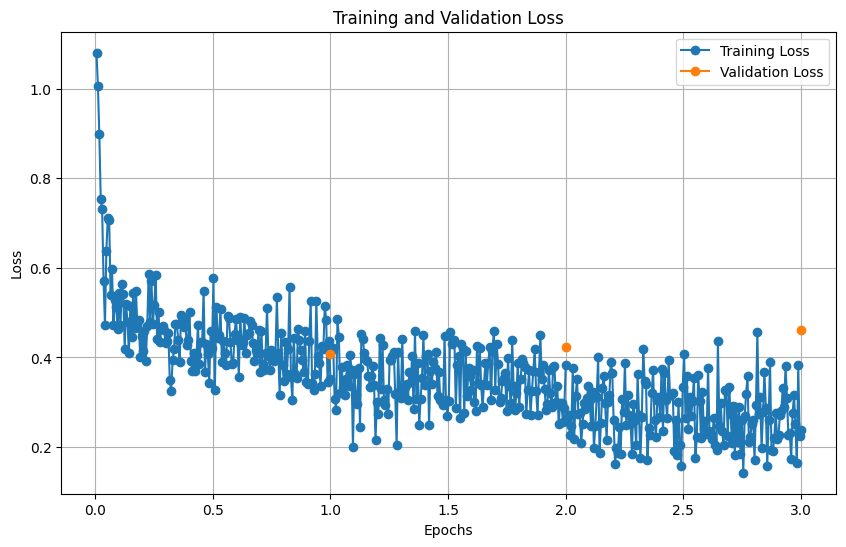

In [13]:
plt.figure(figsize=(10, 6))

# Plot training and validation loss
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
if len(validation_loss) > 0:
    plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')

# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()


In [14]:
sample_reviews = ["The food was amazing!", "Terrible service. Never going back."]
inputs = tokenizer(sample_reviews, return_tensors="pt", truncation=True, padding=True, max_length=128).to("cuda")
outputs = model(**inputs)
predictions = outputs.logits.argmax(dim=1)
print(predictions)  # Output sentiment labels: 0 (Positive), 1 (Negative), 2 (Neutral)


tensor([0, 1], device='cuda:0')


In [15]:
# Define label mapping
label_map = {0: "Positive", 1: "Negative", 2: "Neutral"}

# Convert predictions to labels
predicted_labels = [label_map[pred.item()] for pred in predictions]
print(predicted_labels)


['Positive', 'Negative']


In [16]:
sample_reviews = [
    "The service was outstanding!",
    "The food was okay, but the place was dirty.",
    "I will definitely come back again.",
    "Not worth the money. Avoid this place."
]

inputs = tokenizer(
    sample_reviews,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=128
).to("cuda")

outputs = model(**inputs)
predictions = outputs.logits.argmax(dim=1)
predicted_labels = [label_map[pred.item()] for pred in predictions]

print(predicted_labels)  # Predicted sentiments for the new reviews


['Positive', 'Neutral', 'Positive', 'Negative']


In [17]:
sarcastic_reviews = [
    "Oh great, another delay. Just what I needed.",
    "This place is absolutely amazing... if you like wasting money.",
    "The food was cold, but at least the service was slow."
]
inputs = tokenizer(
    sarcastic_reviews,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=128
).to("cuda")
outputs = model(**inputs)
predictions = outputs.logits.argmax(dim=1)
predicted_labels = [label_map[pred.item()] for pred in predictions]

print(predicted_labels)


['Neutral', 'Positive', 'Neutral']


In [18]:
model.save_pretrained('./sentiment_model')
tokenizer.save_pretrained("./sentiment_model")


('./sentiment_model/tokenizer_config.json',
 './sentiment_model/special_tokens_map.json',
 './sentiment_model/vocab.json',
 './sentiment_model/merges.txt',
 './sentiment_model/added_tokens.json')

In [19]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("./sentiment_model")
tokenizer = AutoTokenizer.from_pretrained("./sentiment_model")


In [20]:
test_dataset = test_dataset.rename_column("sentiment", "labels")


In [21]:
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    return {"eval_accuracy": accuracy}

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
     eval_dataset=test_dataset,
)


In [22]:
metrics = trainer.evaluate(test_dataset)
print(metrics)


{'eval_accuracy': 0.8601796407185629, 'eval_loss': 0.4387739896774292, 'eval_model_preparation_time': 0.0039, 'eval_runtime': 12.5959, 'eval_samples_per_second': 265.166, 'eval_steps_per_second': 16.593}


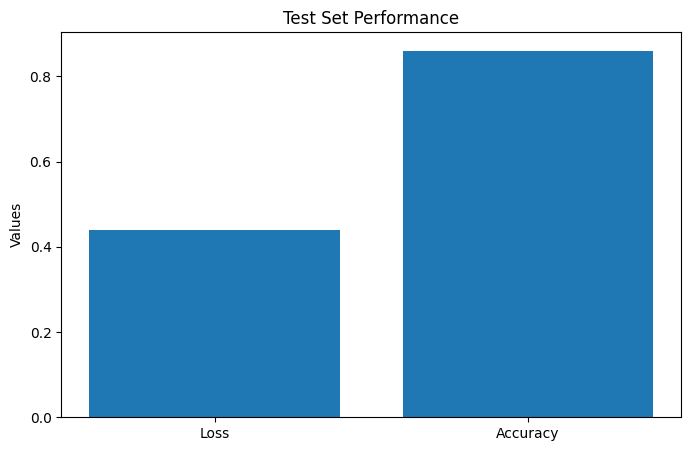

In [23]:
import matplotlib.pyplot as plt

# Extract test loss and accuracy
test_loss = metrics.get('eval_loss', None)
test_accuracy = metrics.get('eval_accuracy', None)

# Plot
if test_loss is not None and test_accuracy is not None:
    plt.figure(figsize=(8, 5))
    plt.bar(['Loss', 'Accuracy'], [test_loss, test_accuracy])
    plt.title('Test Set Performance')
    plt.ylabel('Values')
    plt.show()
else:
    print("Test loss or accuracy not available in metrics.")


In [1]:
!zip sentiment_model.zip sentiment_model
!zip results.zio results

	zip warning: name not matched: sentiment_model

zip error: Nothing to do! (sentiment_model.zip)
	zip warning: name not matched: results

zip error: Nothing to do! (results.zio)
